# ECE 176 -Final Project - Image Inpainting with Autoencoder on CIFAR-10 

## Introduction
This project focuses on image inpainting, a process of reconstructing missing or damaged parts of an image. The approach leverages autoencoder neural networks to learn and generate plausible completions for missing regions based on learned features.

## Dataset
The CIFAR-10 dataset is used in this project, containing 60,000 32x32 color images in 10 classes.

## Preprocessing
- Images are converted to float32 and normalized to the range [0, 1].
- GPU acceleration is utilized for faster computation if available.

## Autoencoder Architecture
- An autoencoder is employed, comprising an encoder and a decoder.
- The encoder compresses input images into a latent representation, while the decoder reconstructs the original images.
- The architecture consists of convolutional layers for both encoding and decoding.

## Training
- The autoencoder is trained using the Adam optimizer and binary cross-entropy loss.
- Training involves reconstructing images with randomly generated missing patches.

## Image Inpainting
- OpenCV is used for inpainting, filling missing regions in images based on surrounding information.
- Inpainted images are then reconstructed using the trained autoencoder.

## Visualization
- The final step involves visualizing different stages of the inpainting process:
    - Original images from the dataset.
    - Images with randomly generated missing patches.
    - Inpainted images using OpenCV.
    - Autoencoder inpainted images, demonstrating the network's ability to generate plausible completions.

## Results
The visualization provides insights into how the autoencoder performs inpainting compared to the OpenCV method.



#### Importing modules and libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
import cv2
import random

2024-03-20 17:43:47.156210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Loading data

In [2]:
import warnings
# Suppress TensorFlow warnings
warnings.filterwarnings("ignore")

# Load CIFAR-10 dataset
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()

In [3]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


#### Preprocessing steps on the CIFAR-10 dataset images

In [4]:
# Convert images to float32
train_images_float32 = tf.cast(train_images, dtype=tf.float32)
test_images_float32 = tf.cast(test_images, dtype=tf.float32)

# Normalize images
train_images = train_images_float32 / 255.0
test_images = test_images_float32 / 255.0

2024-03-20 17:43:54.771339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9986 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


## Autoencoder:

- An autoencoder is a type of neural network used for unsupervised learning, where the input is the same as the output. It consists of two main parts: an encoder and a decoder. The encoder compresses the input data into a latent representation, while the decoder reconstructs the original input data from this latent representation.

- In this code, we are using an autoencoder for image inpainting. Image inpainting is the process of reconstructing missing or damaged parts of an image. By training an autoencoder on a dataset of images with missing patches, we can learn to fill in these patches and generate plausible completions for the missing regions. The encoder learns to extract features from the input images, while the decoder learns to generate the missing parts based on these features.

```
Input (32x32x3)
    │
    │   Encoder
    │---------------------
    │ Conv2D (32 filters, 3x3) -> ReLU
    │ Conv2D (64 filters, 3x3) -> ReLU -> MaxPooling2D (2x2)
    │ Conv2D (64 filters, 3x3) -> ReLU
    │ Conv2D (128 filters, 3x3) -> ReLU -> MaxPooling2D (2x2)
    │ Conv2D (256 filters, 3x3) -> ReLU
    │_____________________
    │             │
    │          Flatten
    │             │
    │             │
    │         Dense (latent vector)
    │             │
    │             │
    │       Reshape (8x8x256)
    │             │
    │             │
    │           Decoder  
    │---------------------
    │ Conv2DTranspose (128 filters, 3x3) -> ReLU
    │ Conv2DTranspose (64 filters, 3x3) -> ReLU -> UpSampling2D (2x2)
    │ Conv2DTranspose (64 filters, 3x3) -> ReLU
    │ Conv2DTranspose (32 filters, 3x3) -> ReLU -> UpSampling2D (2x2)
    │ Conv2DTranspose (3 filters, 3x3) -> Sigmoid
    │_____________________
    │
    │ Output (32x32x3)

```

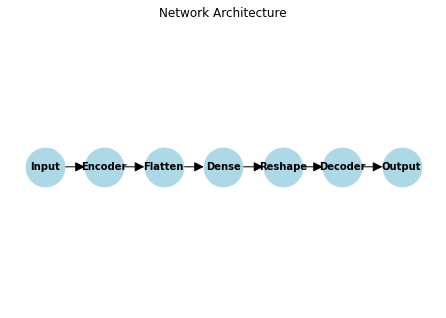

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes and edges
nodes = ['Input', 'Encoder', 'Flatten', 'Dense', 'Reshape', 'Decoder', 'Output']
edges = [('Input', 'Encoder'), ('Encoder', 'Flatten'), ('Flatten', 'Dense'),
         ('Dense', 'Reshape'), ('Reshape', 'Decoder'), ('Decoder', 'Output')]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define positions for each node
pos = {
    'Input': (0, 2),
    'Encoder': (1, 2),
    'Flatten': (2, 2),
    'Dense': (3, 2),
    'Reshape': (4, 2),
    'Decoder': (5, 2),
    'Output': (6, 2)
}

# Draw the graph
nx.draw(G, pos=pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title("Network Architecture")
plt.show()


### Encoder Function
This function constructs the encoder part of the autoencoder. The encoder is responsible for transforming the input data into a compressed representation.
- **Parameters**:
  - `input_shape` (tuple): The shape of the input images.
- **Returns**:
  - `tf.keras.Model`: The encoder model.

In [6]:
def build_encoder(input_shape):
    """
    Build the encoder part of the autoencoder.

    Parameters:
        input_shape (tuple): The shape of the input images.

    Returns:
        tf.keras.Model: The encoder model.
    """
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    return tf.keras.Model(encoder_input, x, name='encoder')


### Decoder function
This function constructs the decoder part of the autoencoder. The decoder is responsible for reconstructing the input data from the compressed representation generated by the encoder.
- **Returns**:
  - `tf.keras.Model`: The decoder model.

In [7]:
def build_decoder():
    """
    Build the decoder part of the autoencoder.

    Returns:
        tf.keras.Model: The decoder model.
    """
    decoder_input = Input(shape=(8, 8, 256), name='decoder_input')
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(decoder_input)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoder_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return tf.keras.Model(decoder_input, decoder_output, name='decoder')

# Example usage:
input_shape = (32, 32, 3)
encoder = build_encoder(input_shape)
decoder = build_decoder()


In [8]:
# Combine encoder and decoder to create autoencoder
autoencoder_input = Input(shape=input_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name='autoencoder')

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(train_images, train_images,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(test_images, test_images))

Epoch 1/50


2024-03-20 17:43:58.870954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-20 17:43:59.874955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fef80d94dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 17:43:59.875012: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-20 17:43:59.885217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-20 17:44:00.121576: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 14s 18ms/step - loss: 0.5817 - val_loss: 0.5598
Epoch 2/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5568 - val_loss: 0.5550
Epoch 3/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5536 - val_loss: 0.5537
Epoch 4/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5518 - val_loss: 0.5521
Epoch 5/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5512 - val_loss: 0.5510
Epoch 6/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5504 - val_loss: 0.5509
Epoch 7/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5502 - val_loss: 0.5502
Epoch 8/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5495 - val_loss: 0.5516
Epoch 9/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5493 - val_loss: 0.5498
Epoch 10/50
391/391 [==============================] - 6s 16ms/step - loss: 0.5490 - val_loss: 0.5495

## Create Patches

This function is used to create patches in a given dataset of images. Patches are regions within an image that are replaced with zeros, simulating missing or damaged parts of the image.

#### Parameters:
- `dataset` (numpy.ndarray): The dataset containing images.
- `patch_size` (tuple): The size of the patches to be created.

#### Returns:
- `numpy.ndarray`: The dataset with patches applied.

#### Method:
- The function creates a copy of the input dataset with zeros.
- It iterates over each image in the dataset.
- For each image, it randomly selects a position `(x, y)` within the image, ensuring that the patch fits entirely within the image.
- It then replaces the region defined by the patch size with zeros, effectively creating a patch in the image.

#### Example Usage:
```python
patch_size = (10, 10)
test_images_with_patches = create_patches(test_images, patch_size)


In [9]:
def create_patches(dataset, patch_size):
    """
    Create patches in the given dataset.

    Parameters:
        dataset (numpy.ndarray): The dataset containing images.
        patch_size (tuple): The size of the patches to be created.

    Returns:
        numpy.ndarray: The dataset with patches applied.
    """
    # Create a copy of the dataset with zeros
    dataset_with_patches = np.copy(dataset)

    # Iterate over the dataset
    for image in range(len(dataset)):
        x = np.random.randint(0, dataset.shape[1] - patch_size[0] + 1)
        y = np.random.randint(0, dataset.shape[2] - patch_size[1] + 1)
        dataset_with_patches[image, x:x+patch_size[0], y:y+patch_size[1], :] = 0.

    return dataset_with_patches

# Example usage:
patch_size = (10, 10)
test_images_with_patches = create_patches(test_images, patch_size)


## Inpaint Images

This function is used to inpaint the given images using OpenCV. Inpainting is the process of reconstructing missing or damaged parts of an image.

#### Parameters:
- `images` (numpy.ndarray): The images to be inpainted.

#### Returns:
- `numpy.ndarray`: The inpainted images.

#### Method:
- The function first creates a copy of the input images array.
- It then iterates over each image in the array.
- For each image, it converts the pixel values to the uint8 data type and scales them to the range [0, 255].
- It calculates a binary mask where pixels with a sum of zero across the color channels are marked as missing.
- Using OpenCV's inpaint function, it fills in the missing regions of the image based on the provided mask.
- Finally, it scales the pixel values back to the range [0, 1] and returns the inpainted images.

#### Example Usage:
```python
test_images_inpainted = inpaint_images(test_images_with_patches)


In [10]:
def inpaint_images(images):
    """
    Inpaint the given images using OpenCV.

    Parameters:
        images (numpy.ndarray): The images to be inpainted.

    Returns:
        numpy.ndarray: The inpainted images.
    """
    inpainted_images = np.copy(images)
    for i in range(len(inpainted_images)):
        img = (inpainted_images[i] * 255).astype(np.uint8)
        mask = np.sum(img, axis=2) == 0
        img = cv2.inpaint(img, mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)
        inpainted_images[i] = img.astype(np.float)/255
    return inpainted_images

# Example usage:
test_images_inpainted = inpaint_images(test_images_with_patches)


### Reconstruct Inpainted Images with Autoencoder

This step involves using the trained autoencoder model to reconstruct the inpainted images. The autoencoder takes the inpainted images as input and generates reconstructed versions of them.

#### Example Usage:
```python
autoencoder_inpainted_images = autoencoder.predict(test_images_inpainted)

In [11]:
# Reconstruct test images inpainted with the model
autoencoder_inpainted_images = autoencoder.predict(test_images_inpainted)

313/313 [==============================] - 1s 3ms/step


## Image Inpainting Visualization

This code snippet visualizes the original images, images with missing patches, inpainted images, and autoencoder inpainted images.

1. **The original images in the Dataset**: This row displays randomly selected original images from the dataset. These images represent the ground truth, i.e., how the images look without any missing patches.

2. **Images with missing patch**: In this row, images from the dataset are shown with randomly generated missing patches. These patches simulate areas where data is missing or damaged.

3. **Inpainted images**: This row displays the inpainted images, where missing patches have been filled using the OpenCV inpainting technique. These images show how the missing regions have been filled in based on the surrounding information.

4. **Autoencoder inpainted images**: The last row represents images inpainted using an autoencoder. Here, the missing patches are filled using an autoencoder trained on images with similar missing patches. These images demonstrate the ability of the autoencoder to learn and generate plausible completions for the missing regions based on the learned features.


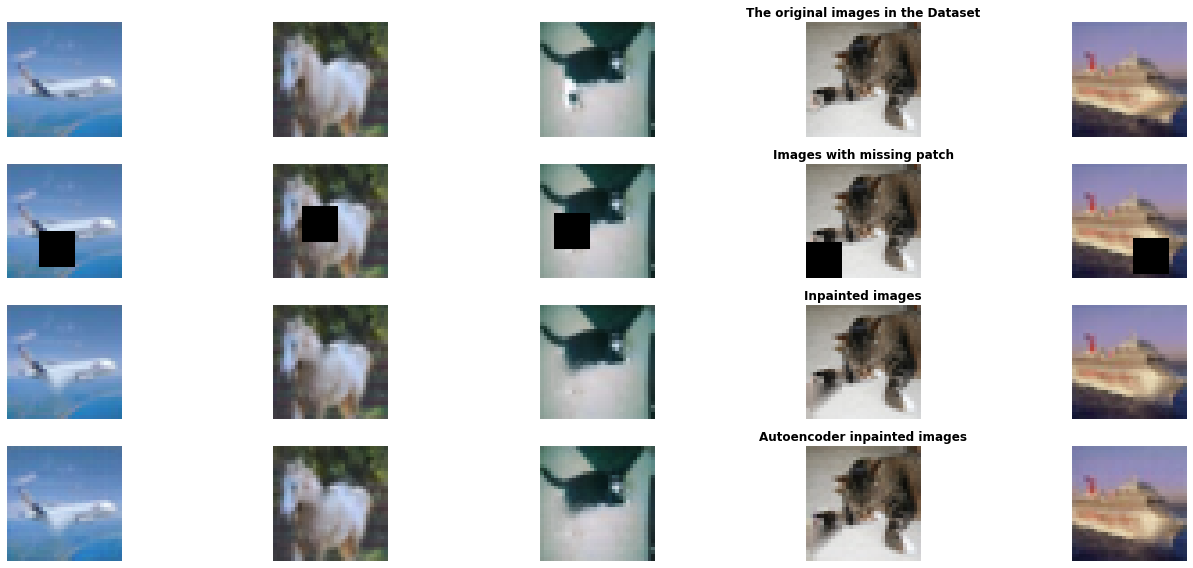

In [12]:
n = 5
fig, axes = plt.subplots(4, n, figsize=(20, 8))

# Randomly select n images from the dataset
random_indices = random.sample(range(len(test_images)), n)

axes[0, 3].set_title('The original images in the Dataset', fontweight='bold', loc='center')  # Set title to bold
axes[1, 3].set_title('Images with missing patch', fontweight='bold', loc='center')  # Set title to bold
axes[2, 3].set_title('Inpainted images', fontweight='bold', loc='center')  # Set title to bold
axes[3, 3].set_title('Autoencoder inpainted images', fontweight='bold', loc='center')  # Set title to bold

for i in range(n):
    # Original image
    axes[0, i].imshow(test_images[random_indices[i]])
    axes[0, i].axis('off')

    # Missing patch
    axes[1, i].imshow(test_images_with_patches[random_indices[i]])
    axes[1, i].axis('off')

    # Inpainted image
    axes[2, i].imshow(test_images_inpainted[random_indices[i]])
    axes[2, i].axis('off')

    # Reconstructed image
    axes[3, i].imshow(autoencoder_inpainted_images[random_indices[i]])
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

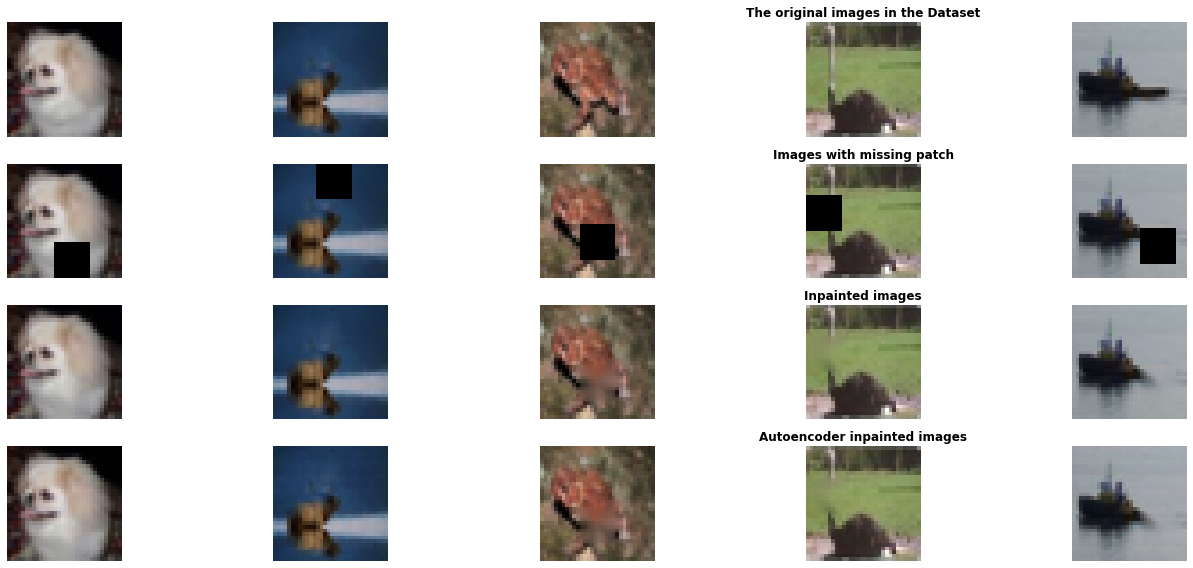

In [13]:
n = 5
fig, axes = plt.subplots(4, n, figsize=(20, 8))

# Randomly select n images from the dataset
random_indices = random.sample(range(len(test_images)), n)

axes[0, 3].set_title('The original images in the Dataset', fontweight='bold', loc='center')  # Set title to bold
axes[1, 3].set_title('Images with missing patch', fontweight='bold', loc='center')  # Set title to bold
axes[2, 3].set_title('Inpainted images', fontweight='bold', loc='center')  # Set title to bold
axes[3, 3].set_title('Autoencoder inpainted images', fontweight='bold', loc='center')  # Set title to bold

for i in range(n):
    # Original image
    axes[0, i].imshow(test_images[random_indices[i]])
    axes[0, i].axis('off')

    # Missing patch
    axes[1, i].imshow(test_images_with_patches[random_indices[i]])
    axes[1, i].axis('off')

    # Inpainted image
    axes[2, i].imshow(test_images_inpainted[random_indices[i]])
    axes[2, i].axis('off')

    # Reconstructed image
    axes[3, i].imshow(autoencoder_inpainted_images[random_indices[i]])
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()